In [1]:
import pandas as pd
import re
import nltk
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Load dataset
file_path = "spam.csv"
df = pd.read_csv(file_path, encoding='latin-1')

In [3]:
# Display first few rows
print("First 5 Rows:")
print(df.head())

First 5 Rows:
     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


In [4]:
# Check basic information
print("\nDataset Info:")
print(df.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
None


In [5]:
# Rename columns
df = df.iloc[:, :2]  # Keep only the first two columns
df.columns = ["label", "message"]  # Rename columns

In [6]:
#Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Check for duplicate values
print("\nDuplicate Values:", df.duplicated().sum())


Missing Values:
label      0
message    0
dtype: int64

Duplicate Values: 403


In [7]:
# Remove duplicate rows
df = df.drop_duplicates()

In [8]:
print("Duplicate Values:", df.duplicated().sum())

Duplicate Values: 0


In [9]:
# Display cleaned dataset info
print("Dataset Info After Cleaning:")
print(df.info())

Dataset Info After Cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 5169 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5169 non-null   object
 1   message  5169 non-null   object
dtypes: object(2)
memory usage: 121.1+ KB
None


In [10]:
# Convert labels to binary (optional)
df["label"] = df["label"].map({"ham": 0, "spam": 1})  # Ham = 0, Spam = 1

In [11]:
# Display class distribution
print("\nClass Distribution:")
print(df["label"].value_counts())


Class Distribution:
label
0    4516
1     653
Name: count, dtype: int64


<ipython-input-12-dc3c6a794d6a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["label"], palette="pastel")


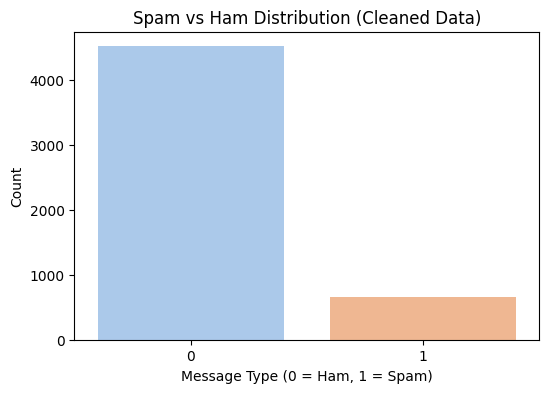

In [12]:
# Plot updated class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df["label"], palette="pastel")
plt.title("Spam vs Ham Distribution (Cleaned Data)")
plt.xlabel("Message Type (0 = Ham, 1 = Spam)")
plt.ylabel("Count")
plt.show()

In [13]:
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    tokens = word_tokenize(text)  # Tokenization
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    return ' '.join(tokens)

In [14]:
df["message"] = df["message"].apply(preprocess_text)

In [15]:
X = df["message"]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [16]:
# Convert text into numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [20]:
# Save vectorizer for later use
with open("tfidf_vectorizer.pkl", "wb") as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

In [17]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vectorized, y_train)


In [18]:
# Show updated dataset info
print("Dataset Info After Preprocessing:")
print(df.info())

Dataset Info After Preprocessing:
<class 'pandas.core.frame.DataFrame'>
Index: 5169 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5169 non-null   int64 
 1   message  5169 non-null   object
dtypes: int64(1), object(1)
memory usage: 121.1+ KB
None


In [21]:
# Show new class distribution after balancing
print("\nUpdated Class Distribution After SMOTE:")
print(pd.Series(y_train_resampled).value_counts())


Updated Class Distribution After SMOTE:
label
0    3613
1    3613
Name: count, dtype: int64


In [22]:
# Save processed data
import pickle
with open("processed_data.pkl", "wb") as f:
    pickle.dump((X_train_vectorized, X_test_vectorized, y_train, y_test, vectorizer), f)

print("✅ Data Preprocessing Complete & Saved!")

✅ Data Preprocessing Complete & Saved!


In [23]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import pickle

nb_model = MultinomialNB()
nb_model.fit(X_train_resampled, y_train_resampled)

y_pred_nb = nb_model.predict(X_test_vectorized)

print(f"✅ Naïve Bayes Accuracy: {accuracy_score(y_test, y_pred_nb):.4f}")
print(f"📊 Classification Report:\n{classification_report(y_test, y_pred_nb)}")

# Save model
with open("nb_model.pkl", "wb") as model_file:
    pickle.dump(nb_model, model_file)

print("✅ Naïve Bayes Model Saved!")


✅ Naïve Bayes Accuracy: 0.9594
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       903
           1       0.78      0.94      0.85       131

    accuracy                           0.96      1034
   macro avg       0.89      0.95      0.92      1034
weighted avg       0.96      0.96      0.96      1034

✅ Naïve Bayes Model Saved!


In [24]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=500)
lr_model.fit(X_train_resampled, y_train_resampled)

y_pred_lr = lr_model.predict(X_test_vectorized)

print(f"✅ Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"📊 Classification Report:\n{classification_report(y_test, y_pred_lr)}")

# Save model
with open("lr_model.pkl", "wb") as model_file:
    pickle.dump(lr_model, model_file)

print("✅ Logistic Regression Model Saved!")


✅ Logistic Regression Accuracy: 0.9758
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       903
           1       0.90      0.92      0.91       131

    accuracy                           0.98      1034
   macro avg       0.94      0.95      0.95      1034
weighted avg       0.98      0.98      0.98      1034

✅ Logistic Regression Model Saved!


In [25]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train_resampled, y_train_resampled)

y_pred_rf = rf_model.predict(X_test_vectorized)

print(f"✅ Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"📊 Classification Report:\n{classification_report(y_test, y_pred_rf)}")

# Save model
with open("rf_model.pkl", "wb") as model_file:
    pickle.dump(rf_model, model_file)

print("✅ Random Forest Model Saved!")


✅ Random Forest Accuracy: 0.9797
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       903
           1       0.99      0.85      0.91       131

    accuracy                           0.98      1034
   macro avg       0.98      0.92      0.95      1034
weighted avg       0.98      0.98      0.98      1034

✅ Random Forest Model Saved!


In [26]:
from sklearn.svm import SVC

svm_model = SVC(kernel="linear", C=1.0)
svm_model.fit(X_train_resampled, y_train_resampled)

y_pred_svm = svm_model.predict(X_test_vectorized)

print(f"✅ SVM Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"📊 Classification Report:\n{classification_report(y_test, y_pred_svm)}")

# Save model
with open("svm_model.pkl", "wb") as model_file:
    pickle.dump(svm_model, model_file)

print("✅ SVM Model Saved!")


✅ SVM Accuracy: 0.9807
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       903
           1       0.92      0.93      0.92       131

    accuracy                           0.98      1034
   macro avg       0.95      0.96      0.96      1034
weighted avg       0.98      0.98      0.98      1034

✅ SVM Model Saved!


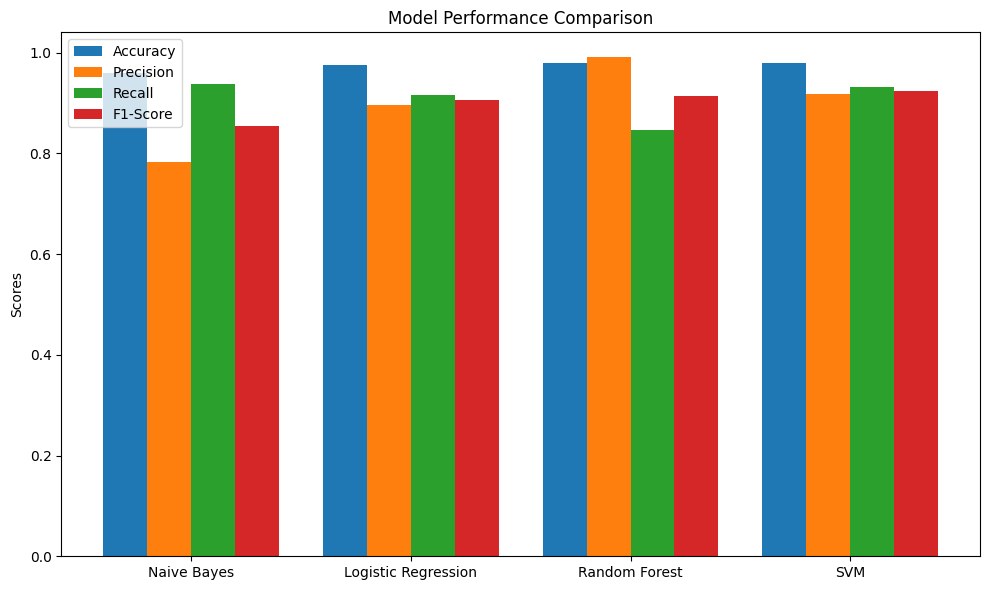

In [36]:

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have y_test and predictions for each model (y_pred_nb, y_pred_lr, y_pred_rf, y_pred_svm)

models = ['Naive Bayes', 'Logistic Regression', 'Random Forest', 'SVM']
y_preds = [y_pred_nb, y_pred_lr, y_pred_rf, y_pred_svm]

# Create lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for y_pred in y_preds:
  accuracy_scores.append(accuracy_score(y_test, y_pred))
  precision_scores.append(precision_score(y_test, y_pred, zero_division=0))
  recall_scores.append(recall_score(y_test, y_pred, zero_division=0))
  f1_scores.append(f1_score(y_test, y_pred, zero_division=0))

# Create a bar plot
x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - 1.5 * width, accuracy_scores, width, label='Accuracy')
rects2 = ax.bar(x - 0.5 * width, precision_scores, width, label='Precision')
rects3 = ax.bar(x + 0.5 * width, recall_scores, width, label='Recall')
rects4 = ax.bar(x + 1.5 * width, f1_scores, width, label='F1-Score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Adjust layout to prevent overlapping
fig.tight_layout()

plt.show()

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder

# Tokenize text
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_length = max(len(seq) for seq in X_train_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding="post")

# Encode labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

# Build LSTM Model
lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_length),
    SpatialDropout1D(0.2),
    LSTM(100),
    Dense(1, activation="sigmoid")
])

lstm_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train model
lstm_model.fit(X_train_pad, y_train_enc, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test_enc))

# Save model
lstm_model.save("lstm_model.keras")

print("✅ LSTM Model Saved!")


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 159ms/step - accuracy: 0.8427 - loss: 0.4158 - val_accuracy: 0.8733 - val_loss: 0.3829
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - accuracy: 0.8666 - loss: 0.3950 - val_accuracy: 0.8733 - val_loss: 0.3856
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 0.8635 - loss: 0.4014 - val_accuracy: 0.8733 - val_loss: 0.3894
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 22s 102ms/step - accuracy: 0.8728 - loss: 0.3851 - val_accuracy: 0.8733 - val_loss: 0.3831
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - accuracy: 0.8713 - loss: 0.3861 - val_accuracy: 0.8733 - val_loss: 0.3805
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - accuracy: 0.8794 - loss: 0.3708 - val_accuracy: 0.8733 - val_loss: 0.3809
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 22s 97ms/step - accuracy: 0.8753 - loss: 0.3768 - val_accuracy: 0.8733 - val_loss: 0.3807
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - accuracy: 0.8761 - loss: 0.3750 - val_accur

In [28]:
from tensorflow.keras.layers import GRU

gru_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_length),
    SpatialDropout1D(0.2),
    GRU(100),
    Dense(1, activation="sigmoid")
])

gru_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train model
gru_model.fit(X_train_pad, y_train_enc, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test_enc))

# Save model
gru_model.save("gru_model.keras")

print("✅ GRU Model Saved!")


Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - accuracy: 0.8760 - loss: 0.4241 - val_accuracy: 0.8733 - val_loss: 0.3809
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.8790 - loss: 0.3704 - val_accuracy: 0.8733 - val_loss: 0.3807
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.8783 - loss: 0.3736 - val_accuracy: 0.8733 - val_loss: 0.3826
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.8678 - loss: 0.3918 - val_accuracy: 0.8733 - val_loss: 0.3835
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.8627 - loss: 0.4031 - val_accuracy: 0.8733 - val_loss: 0.3806
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.8788 - loss: 0.3715 - val_accuracy: 0.8733 - val_loss: 0.3815
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.8773 - loss: 0.3736 - val_accuracy: 0.8733 - val_loss: 0.3810
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.8676 - loss: 0.3923 -

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


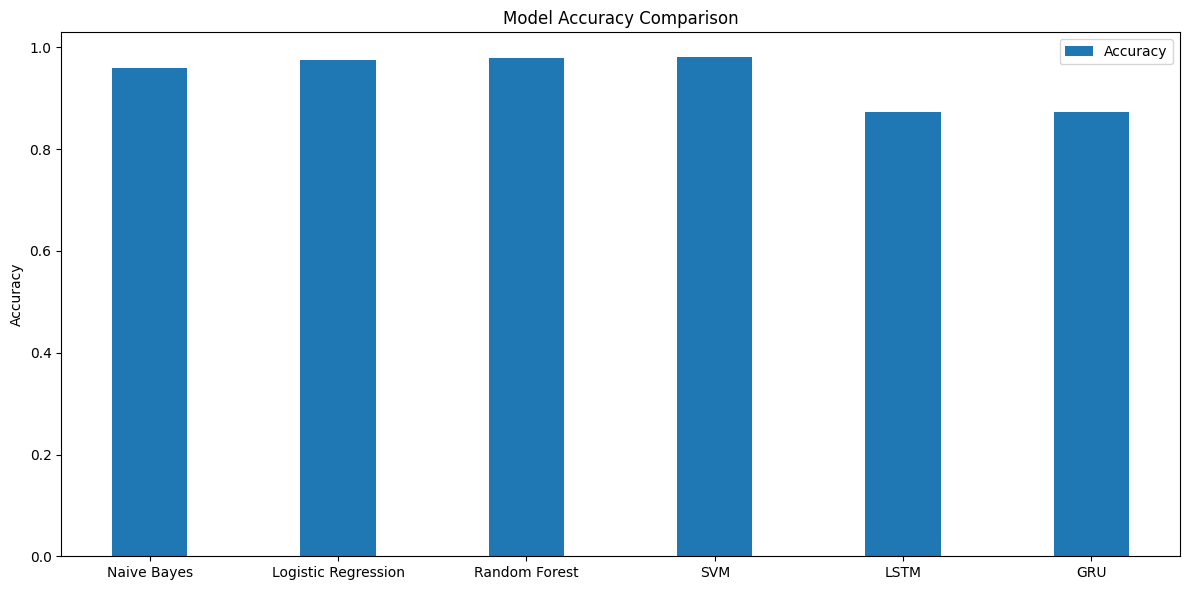

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have already trained and made predictions for LSTM and GRU models
# Replace these with your actual predictions
y_pred_lstm = lstm_model.predict(X_test_pad)
y_pred_gru = gru_model.predict(X_test_pad)

# Convert predictions to binary (0 or 1)
y_pred_lstm = (y_pred_lstm > 0.5).astype("int32")
y_pred_gru = (y_pred_gru > 0.5).astype("int32")


models = ['Naive Bayes', 'Logistic Regression', 'Random Forest', 'SVM', 'LSTM', 'GRU']
y_preds = [y_pred_nb, y_pred_lr, y_pred_rf, y_pred_svm, y_pred_lstm, y_pred_gru]

# Create lists to store evaluation metrics
accuracy_scores = []

for y_pred in y_preds:
  accuracy_scores.append(accuracy_score(y_test, y_pred))


# Create a bar plot
x = np.arange(len(models))
width = 0.4  # Adjust bar width as needed


fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x, accuracy_scores, width, label='Accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Adjust layout to prevent overlapping
fig.tight_layout()

plt.show()


In [86]:
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

# Save TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Impute missing values with an empty string before fitting the vectorizer
df['clean_text'] = df['clean_text'].fillna('')

X_tfidf = tfidf_vectorizer.fit_transform(df['clean_text'])

# Train Final Random Forest Model
final_rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
final_rf_model.fit(X_tfidf, df['label'])

# Save Model & Vectorizer
with open("spam_detector.pkl", "wb") as model_file:
    pickle.dump(final_rf_model, model_file)

with open("tfidf_vectorizer.pkl", "wb") as vectorizer_file:
    pickle.dump(tfidf_vectorizer, vectorizer_file)

print("✅ Model & Vectorizer Saved Successfully!")

✅ Model & Vectorizer Saved Successfully!


In [31]:
import pickle
import numpy as np

# Load Model & Vectorizer
with open("rf_model.pkl", "rb") as model_file:
    loaded_model = pickle.load(model_file)

with open("tfidf_vectorizer.pkl", "rb") as vectorizer_file:
    loaded_vectorizer = pickle.load(vectorizer_file)

# Function to Predict Spam/Ham
def predict_sms(text):
    text_cleaned = preprocess_text(text)  # Error occurs here
    text_tfidf = loaded_vectorizer.transform([text_cleaned])
    prediction = loaded_model.predict(text_tfidf)
    return "Spam" if prediction == 1 else "Ham"

# Example Usage
print(predict_sms("Congratulations! You won a free trip to Dubai!"))
print(predict_sms("WINNER!! As a valued network customer you have been selected to receivea �900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only"))
print(predict_sms("URGENT: Your bank account has been compromised. Verify details now!"))


Ham
Spam
Ham
